# Exploratory Data Analysis (EDA)  

In this notebook, we load our pollen dataset (2D views generated from STL models) and analyze:  

- The number of models in the dataset  
- Visualization of randomly selected samples (left and right views, combined view)  
- Calculation of a simple disparity/depth map using OpenCV Stereo Block Matching  
- Visualization of a histogram of brightness values  

**Note:** The `PollenDataset` class is imported from a separate folder.

In [1]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from dotenv import load_dotenv

load_dotenv()

sys.path.append("..")
from data import PollenDataset

## Dataset-Instance

In [2]:
DATA_DIR = os.getenv("DATA_DIR_PATH")


dataset = PollenDataset(data_dir=DATA_DIR, return_3d=False)
print(f"Number of Pollen Grain Meshes present: {len(dataset)}")

Number of Pollen Grain Meshes present: 207


## Beispiel-Sample visualisieren

Wir wählen ein zufälliges Sample aus dem Dataset, zeigen die linke und rechte Ansicht einzeln an und kombinieren beide Bilder zu einer Gesamtansicht.

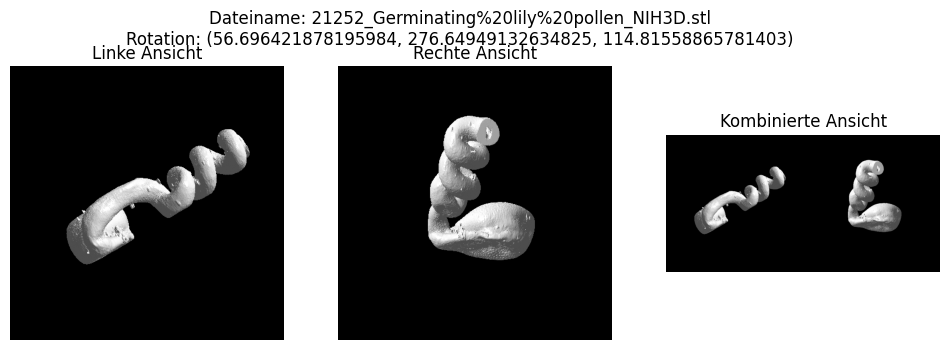

In [3]:
idx = random.randint(0, len(dataset) - 1)
sample = dataset[idx]
left = sample["left_view"]
right = sample["right_view"]
rotation = sample["rotation"]
filename = sample["file_name"]

combined = np.concatenate((left, right), axis=1)

# Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(left, cmap="gray")
plt.title("Linke Ansicht")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(right, cmap="gray")
plt.title("Rechte Ansicht")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(combined, cmap="gray")
plt.title("Kombinierte Ansicht")
plt.axis("off")
plt.suptitle(f"Dateiname: {filename}\nRotation: {rotation}")
plt.show()

## Berechnung einer Disparitäts-/Depth-Map (Proxy)

Mithilfe von OpenCV und StereoBM berechnen wir eine einfache Disparitätskarte aus den beiden Ansichten. Diese kann als grober Proxy für eine Depth Map genutzt werden – beachten, dass diese Methode voraussetzt, dass beide Bilder gut korrespondieren.

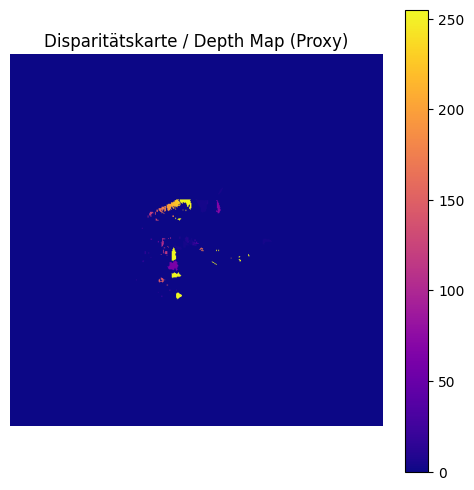

In [4]:
left_np = np.array(left)
right_np = np.array(right)

left_uint8 = cv2.normalize(left_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
right_uint8 = cv2.normalize(right_np, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


numDisparities = 64
blockSize = 15
stereo = cv2.StereoBM_create(numDisparities=numDisparities, blockSize=blockSize)

disparity = stereo.compute(left_uint8, right_uint8).astype(np.float32)

disp_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disp_norm = np.uint8(disp_norm)

plt.figure(figsize=(6, 6))
plt.imshow(disp_norm, cmap="plasma")
plt.title("Disparitätskarte / Depth Map (Proxy)")
plt.axis("off")
plt.colorbar()
plt.show()

# 3D-Modell Bereinigungspipeline

## Übersicht der MeshCleaner-Klasse

Die `MeshCleaner`-Klasse bietet eine umfassende Pipeline zur Verarbeitung, Analyse und Bereinigung von 3D-STL-Modellen. Sie ist besonders für die Vorbereitung von 3D-Modellen für maschinelles Lernen, Visualisierung oder 3D-Druck konzipiert.

## Hauptfunktionen

- **Modelleanalyse**: Berechnung von geometrischen Eigenschaften und Qualitätsmetriken
- **Modellbereinigung**: Entfernung von Defekten, Füllung von Löchern
- **Modellnormalisierung**: Skalierung, Zentrierung und Orientierung
- **Visualisierung**: Erstellung von Statistiken und Diagrammen der Modellanalyse

## Dreistufige Löcherfüllung

Die Pipeline implementiert eine fortschrittliche dreistufige Strategie zum Füllen von Löchern:

### 1. Kleine Löcher (trimesh.fill_holes)
- **Methode**: Native trimesh-Funktionalität
- **Geeignet für**: Kleine, einfache Löcher
- **Vorteile**: Schnell und effizient für simple Defekte

### 2. Mittelgroße Löcher (vtkFillHolesFilter)
- **Methode**: VTK-Bibliotheksfunktionen
- **Geeignet für**: Mittelgroße Löcher mit moderater Komplexität
- **Vorteile**: Robust für größere Löcher, wo trimesh versagt

### 3. Komplexe Löcher (manifold3d)
- **Methode**: Manifold-Reparatur-Algorithmus
- **Geeignet für**: Komplexe Topologie, multiple oder große Lücken
- **Vorteile**: Kann auch stark beschädigte Meshes reparieren

## Workflow

1. Das Modell wird geladen und grundlegende Statistiken werden erfasst
2. Unreferenzierte Vertices werden entfernt
3. Die dreistufige Löcherfüllung wird angewendet (falls aktiviert)
4. Doppelte Faces werden entfernt (falls aktiviert)
5. Das Modell wird skaliert (falls aktiviert)
6. Das Modell wird zentriert (falls aktiviert)
7. Das bereinigte Modell wird gespeichert
8. Statistische Berichte und Visualisierungen werden erstellt

## Abhängigkeiten

Die Pipeline nutzt mehrere spezialisierte Bibliotheken:




Die Software prüft nach jeder Bearbeitung, ob die Modelle wasserdicht sind, und erstellt eine Liste von Modellen, die weiterhin Probleme aufweisen. Diese können dann gezielt nachbearbeitet werden.

In [ ]:
import os
import trimesh
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import manifold3d as manifold
import scipy
from pyntcloud import PyntCloud

class MeshCleaner:
    def __init__(
        self,
        data_dir="../data/raw/models",
        output_dir="../data/processed/models",
        fill_holes=True,
        remove_duplicates=True,
        scale=True,
        center=True,
        remove_self_intersections=False,
        fix_normals=False,
        optimize_quality=False,
        smooth_surface=False,
        simplify_large_meshes=False,
    ):
        self.data_dir = data_dir
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)

        self.fill_holes = fill_holes  # Aktiviert die Löcherfüllung insgesamt
        self.remove_duplicates = remove_duplicates
        self.scale = scale
        self.center = center
        self.remove_self_intersections = remove_self_intersections
        self.fix_normals = fix_normals
        self.optimize_quality = optimize_quality
        self.smooth_surface = smooth_surface
        self.simplify_large_meshes = simplify_large_meshes

    def analyze_mesh(self, mesh_path):
        """Lädt und analysiert ein STL-Mesh mit erweiterten Metriken."""
        try:
            mesh = trimesh.load_mesh(mesh_path)

            # Grundlegende Geometrie
            stats = {
                "file_name": os.path.basename(mesh_path),
                "num_vertices": len(mesh.vertices),
                "num_faces": len(mesh.faces),
                "bounding_box": mesh.bounds,
                "extents": mesh.extents.tolist(),
                "surface_area": mesh.area,
                "is_watertight": mesh.is_watertight,
                "euler_number": mesh.euler_number,  # Topologie-Indikator (V-E+F)
            }

            # Volumen nur für wasserdichte Modelle
            try:
                if mesh.is_watertight:
                    stats["volume"] = mesh.volume
                    # Konvexität (Verhältnis von Volumen zu konvexer Hülle)
                    try:
                        hull = mesh.convex_hull
                        if hull.volume > 0:
                            stats["convexity_ratio"] = mesh.volume / hull.volume
                    except:
                        pass
            except:
                pass

            # Kantenstatistiken
            try:
                edges = mesh.edges_unique
                if len(edges) > 0:
                    edge_lengths = [
                        np.linalg.norm(mesh.vertices[e[0]] - mesh.vertices[e[1]])
                        for e in edges
                    ]
                    stats["mean_edge_length"] = np.mean(edge_lengths)
                    stats["min_edge_length"] = np.min(edge_lengths)
                    stats["max_edge_length"] = np.max(edge_lengths)
                    stats["edge_length_std"] = np.std(edge_lengths)
            except:
                pass

            # Flächenorientierung
            try:
                if len(mesh.faces) > 0 and hasattr(mesh, "face_normals"):
                    consistent = mesh.face_normals.dot(mesh.face_normals[0]) > 0
                    stats["normal_consistency"] = np.mean(consistent)
            except:
                pass

            # Punktdichte und Seitenverhältnis
            try:
                if np.prod(mesh.extents) > 0:
                    stats["point_density"] = len(mesh.vertices) / np.prod(mesh.extents)
                if min(mesh.extents) > 0:
                    stats["aspect_ratio"] = max(mesh.extents) / min(mesh.extents)
            except:
                pass

            return stats
        except Exception as e:
            print(f"Fehler bei der Analyse von {mesh_path}: {str(e)}")
            return {"file_name": os.path.basename(mesh_path), "error": str(e)}

    def plot_mesh(self, mesh_path):
        """Visualisiert ein STL-Modell."""
        try:
            mesh = trimesh.load_mesh(mesh_path)
            mesh.show()
        except Exception as e:
            print(f"Fehler beim Visualisieren: {str(e)}")

    def fill_holes_advanced(self, mesh):
        """Füllt Löcher mit verschiedenen Methoden je nach Komplexität."""
        original_watertight = mesh.is_watertight
        hole_fill_method = "Keine"

        # Stufe 1: Versuche trimesh für kleine Löcher
        if not mesh.is_watertight and hasattr(mesh, "fill_holes"):
            try:
                mesh.fill_holes()
                if mesh.is_watertight:
                    hole_fill_method = "trimesh"
            except Exception as e:
                print(f"  Trimesh fill_holes fehlgeschlagen: {str(e)}")

        # Stufe 2: Versuche VTK für mittelgroße Löcher
        if not mesh.is_watertight:
            try:
                import vtk
                from vtk.util import numpy_support

                # Konvertiere trimesh zu VTK PolyData
                points = vtk.vtkPoints()
                for v in mesh.vertices:
                    points.InsertNextPoint(v)

                triangles = vtk.vtkCellArray()
                for f in mesh.faces:
                    triangle = vtk.vtkTriangle()
                    for i in range(3):
                        triangle.GetPointIds().SetId(i, f[i])
                    triangles.InsertNextCell(triangle)

                poly_data = vtk.vtkPolyData()
                poly_data.SetPoints(points)
                poly_data.SetPolys(triangles)

                # Anwenden des Loch-Füll-Filters
                fill_filter = vtk.vtkFillHolesFilter()
                fill_filter.SetInputData(poly_data)
                fill_filter.SetHoleSize(
                    mesh.scale * 0.01
                )  # Anpassen je nach Modellgröße
                fill_filter.Update()

                # Extrahiere gefülltes Mesh
                filled_poly = fill_filter.GetOutput()

                # Konvertiere zurück zu Trimesh
                vertices = []
                for i in range(filled_poly.GetNumberOfPoints()):
                    vertices.append(filled_poly.GetPoint(i))
                vertices = np.array(vertices)

                faces = []
                for i in range(filled_poly.GetNumberOfCells()):
                    cell = filled_poly.GetCell(i)
                    if cell.GetNumberOfPoints() == 3:  # Nur Dreiecke
                        face = [cell.GetPointId(j) for j in range(3)]
                        faces.append(face)
                faces = np.array(faces)

                # Erstelle neues Trimesh mit gefüllten Löchern
                filled_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

                if filled_mesh.is_watertight:
                    mesh = filled_mesh
                    hole_fill_method = "vtk"
            except Exception as e:
                print(f"  VTK fill_holes fehlgeschlagen: {str(e)}")

        # Stufe 3: Versuche manifold3d für komplexe Löcher
                if not mesh.is_watertight:
                    try:
                        # Konvertiere zu manifold3d
                        manifold_mesh = manifold3d.Mesh(mesh.vertices, mesh.faces)
                        mesh_manifold = manifold3d.Manifold(manifold_mesh)
        
                        # Repariere das Mesh
                        mesh_manifold = mesh_manifold.fix()
                        mesh_manifold = mesh_manifold.compact()
        
                        # Konvertiere zurück zu trimesh
                        mani_mesh = mesh_manifold.to_mesh()
                        fixed_mesh = trimesh.Trimesh(vertices=mani_mesh.v, faces=mani_mesh.f)
        
                        if fixed_mesh.is_watertight:
                            mesh = fixed_mesh
                            hole_fill_method = "manifold3d"
                    except Exception as e:
                        print(f"  Manifold3d fix fehlgeschlagen: {str(e)}")
        
                return mesh, hole_fill_method, original_watertight

        return mesh, hole_fill_method, original_watertight

    def clean_mesh(self, mesh_path, output_path):
        """Lädt, bereinigt und speichert ein STL-Mesh mit erweiterter Löcherfüllung."""
        try:
            mesh = trimesh.load_mesh(mesh_path)
            file_name = os.path.basename(mesh_path)
            original_stats = {
                "vertices": len(mesh.vertices),
                "faces": len(mesh.faces),
                "is_watertight": mesh.is_watertight,
            }

            print(f"Verarbeite {file_name}: Wasserdicht={mesh.is_watertight}")

            # Entferne ungenutzte Vertices und Faces
            mesh.remove_unreferenced_vertices()

            if self.fill_holes:
                mesh, method_used, was_watertight = self.fill_holes_advanced(mesh)
                if mesh.is_watertight and not was_watertight:
                    print(f"  ✓ Löcher erfolgreich gefüllt mit {method_used}")
                elif not mesh.is_watertight:
                    print(f"  ✗ Mesh ist nach Reparatur immer noch nicht wasserdicht")

            if self.remove_duplicates:
                # Aktualisierte Methode zum Entfernen doppelter Faces
                mesh.update_faces(mesh.unique_faces())

            if self.scale:
                max_dim = max(mesh.extents)
                if max_dim > 0:
                    mesh.apply_scale(1.0 / max_dim)

            # Self-Intersections entfernen
            if self.remove_self_intersections:
                mesh = self.remove_self_intersections(mesh)

            # Normalen korrigieren
            if self.fix_normals:
                mesh = self.fix_normals(mesh)

            # Lochfüllung (verbesserte Methode)
            if self.fill_holes:
                mesh, method_used, was_watertight = self.fill_holes_advanced(mesh)

            # Oberfläche glätten falls gewünscht
            if self.smooth_surface:
                mesh = self.smooth_mesh(mesh, method="taubin", iterations=3)

            # Mesh vereinfachen falls notwendig
            if self.simplify_large_meshes and len(mesh.faces) > 100000:
                mesh = self.simplify_mesh(mesh, target_percent=0.5)

            # Facettenqualität optimieren
            if self.optimize_quality:
                mesh = self.optimize_mesh_quality(mesh)

            if self.center:
                centroid = mesh.centroid
                mesh.apply_translation(-centroid)

            mesh.export(output_path)

            cleaned_stats = {
                "vertices": len(mesh.vertices),
                "faces": len(mesh.faces),
                "is_watertight": mesh.is_watertight,
                "hole_fill_method": method_used
                if "method_used" in locals()
                else "None",
            }

            status = "✓" if mesh.is_watertight else "✗"
            print(
                f"{status} Gespeichert: {os.path.basename(output_path)} "
                + f"(Vertices: {original_stats['vertices']} → {cleaned_stats['vertices']}, "
                + f"Faces: {original_stats['faces']} → {cleaned_stats['faces']}, "
                + f"Wasserdicht: {original_stats['is_watertight']} → {cleaned_stats['is_watertight']})"
            )

            return cleaned_stats
        except Exception as e:
            print(f"Fehler beim Bereinigen des Meshes {mesh_path}: {str(e)}")
            return {"file_name": os.path.basename(mesh_path), "error": str(e)}

    def verify_models(self, models_dir):
        """Überprüft alle Modelle auf Wasserdichtigkeit und erstellt einen Bericht."""
        print("\nÜberprüfe Wasserdichtigkeit der bereinigten Modelle...")
        watertight_models = 0
        non_watertight_models = []

        all_models = [f for f in os.listdir(models_dir) if f.endswith(".stl")]
        for model_file in tqdm(all_models, desc="Überprüfe Modelle"):
            model_path = os.path.join(models_dir, model_file)
            try:
                mesh = trimesh.load_mesh(model_path)
                if mesh.is_watertight:
                    watertight_models += 1
                else:
                    non_watertight_models.append(model_file)
            except Exception as e:
                print(f"Fehler beim Laden von {model_file}: {str(e)}")
                non_watertight_models.append(f"{model_file} (Ladefehler)")

        # Erstelle Bericht
        print(
            f"\nWasserdichte Modelle: {watertight_models}/{len(all_models)} ({watertight_models / len(all_models) * 100:.1f}%)"
        )
        if non_watertight_models:
            print(
                f"Folgende {len(non_watertight_models)} Modelle sind nicht wasserdicht:"
            )
            for i, model in enumerate(
                non_watertight_models[:10], 1
            ):  # Zeige nur die ersten 10
                print(f"  {i}. {model}")
            if len(non_watertight_models) > 10:
                print(f"  ... und {len(non_watertight_models) - 10} weitere")

            # Speichere problematische Modelle in eine Datei
            with open("non_watertight_models.txt", "w") as f:
                for model in non_watertight_models:
                    f.write(f"{model}\n")

            print(
                "Liste aller problematischen Modelle in 'non_watertight_models.txt' gespeichert."
            )

        return watertight_models, non_watertight_models

    def analyze_pointcloud(self, mesh_path):
        """Analysiert das Mesh als Punktwolke für grundlegende Statistiken."""
        try:
            # Überprüfen, ob PyntCloud verfügbar ist
            if "PyntCloud" not in globals():
                return {"file_name": os.path.basename(mesh_path)}

            mesh = trimesh.load_mesh(mesh_path)
            # Verwende eine Stichprobe für große Meshes
            points = mesh.sample(2000) if len(mesh.vertices) > 2000 else mesh.vertices

            if len(points) == 0:
                return {"file_name": os.path.basename(mesh_path)}

            # Einfache geometrische Statistiken ohne problematische Eigenwertberechnung
            points_df = pd.DataFrame(points, columns=["x", "y", "z"])

            # Berechne grundlegende statistische Maße
            stats = {
                "file_name": os.path.basename(mesh_path),
                "point_mean_x": np.mean(points_df["x"]),
                "point_mean_y": np.mean(points_df["y"]),
                "point_mean_z": np.mean(points_df["z"]),
                "point_std_x": np.std(points_df["x"]),
                "point_std_y": np.std(points_df["y"]),
                "point_std_z": np.std(points_df["z"]),
            }

            # Füge Maße für die Verteilung hinzu
            for col in ["x", "y", "z"]:
                stats[f"point_{col}_skew"] = 0  # Platzhalter für Schiefe
                stats[f"point_{col}_kurtosis"] = 0  # Platzhalter für Wölbung

                # Versuche Schiefe und Wölbung zu berechnen, wenn scipy verfügbar ist
                try:
                    from scipy import stats as scipystats

                    stats[f"point_{col}_skew"] = scipystats.skew(points_df[col])
                    stats[f"point_{col}_kurtosis"] = scipystats.kurtosis(points_df[col])
                except:
                    pass

            return stats

        except Exception as e:
            print(f"Fehler bei der Punktwolkenanalyse: {str(e)}")
            return {"file_name": os.path.basename(mesh_path)}

    def visualize_results(self, df):
        """Erstellt Visualisierungen zu den Analyseergebnissen."""
        if len(df) == 0:
            return

        # Entferne nicht-numerische Spalten für Korrelationsanalyse
        try:
            # 1. Korrelationsmatrix für numerische Werte
            num_cols = df.select_dtypes(include=[np.number]).columns
            if len(num_cols) >= 2:
                plt.figure(figsize=(12, 10))
                corr_matrix = df[num_cols].corr()
                plt.matshow(corr_matrix, fignum=1, cmap="coolwarm")
                plt.colorbar()
                plt.xticks(range(len(num_cols)), num_cols, rotation=90)
                plt.yticks(range(len(num_cols)), num_cols)
                plt.title("Korrelation zwischen Mesh-Eigenschaften")
                plt.savefig("mesh_correlation.png")
                plt.close()
        except Exception as e:
            print(f"Fehler bei Korrelationsanalyse: {str(e)}")

        try:
            # 2. Scatterplot für wichtige Eigenschaften
            key_metrics = ["num_vertices", "num_faces"]
            if all(metric in df.columns for metric in key_metrics):
                plt.figure(figsize=(10, 8))
                plt.scatter(
                    df["num_vertices"],
                    df["num_faces"],
                    c=df["is_watertight"] if "is_watertight" in df.columns else None,
                    alpha=0.7,
                    s=50,
                )

                # Beschriftungen für nur wenige Datenpunkte
                if len(df) <= 30:
                    for i, txt in enumerate(df["file_name"]):
                        plt.annotate(
                            txt,
                            (df["num_vertices"].iloc[i], df["num_faces"].iloc[i]),
                            fontsize=8,
                        )

                plt.xlabel("Anzahl Vertices")
                plt.ylabel("Anzahl Faces")
                plt.title("Mesh-Komplexität")
                plt.grid(True, alpha=0.3)
                plt.savefig("mesh_complexity.png")
                plt.close()

            # 3. Histogramm für Wasserdichtigkeit
            if "is_watertight" in df.columns:
                plt.figure(figsize=(8, 6))
                watertight_count = df["is_watertight"].sum()
                counts = [watertight_count, len(df) - watertight_count]
                plt.bar(
                    ["Wasserdicht", "Nicht wasserdicht"], counts, color=["green", "red"]
                )
                plt.title("Wasserdichtigkeit der Meshes")
                plt.savefig("mesh_watertight.png")
                plt.close()

        except Exception as e:
            print(f"Fehler beim Erstellen der Visualisierungen: {str(e)}")

        def smooth_mesh(
            self, mesh, method="laplacian", iterations=5, preserve_volume=True
        ):
            """Glättet ein Mesh zur Reduzierung von Rauschen und Artefakten."""
            try:
                if method == "laplacian":
                    # Einfaches Laplacian Smoothing
                    for _ in range(iterations):
                        # Berechne neue Vertex-Positionen als Durchschnitt der Nachbarn
                        adjacency = mesh.vertex_adjacency_graph
                        new_vertices = mesh.vertices.copy()

                        for i in range(len(mesh.vertices)):
                            if i in adjacency:
                                neighbors = list(adjacency[i])
                                if neighbors:
                                    neighbor_verts = mesh.vertices[neighbors]
                                    new_vertices[i] = np.mean(neighbor_verts, axis=0)

                        # Wende neue Positionen an
                        original_volume = None
                        if preserve_volume:
                            original_volume = (
                                mesh.volume if mesh.is_watertight else None
                            )

                        mesh.vertices = new_vertices

                        # Volumenerhaltung
                        if (
                            preserve_volume
                            and original_volume
                            and mesh.is_watertight
                            and mesh.volume > 0
                        ):
                            scale_factor = (original_volume / mesh.volume) ** (1 / 3)
                            mesh.apply_scale(scale_factor)

                elif method == "taubin":
                    # Taubin Smoothing (reduziert Schrumpfung)
                    lambda_factor = 0.5
                    mu_factor = -0.53  # Typischerweise leicht größer als -lambda

                    for _ in range(iterations):
                        # Lambda-Schritt (Vorwärts)
                        adjacency = mesh.vertex_adjacency_graph
                        new_vertices = mesh.vertices.copy()

                        for i in range(len(mesh.vertices)):
                            if i in adjacency:
                                neighbors = list(adjacency[i])
                                if neighbors:
                                    neighbor_verts = mesh.vertices[neighbors]
                                    delta = (
                                        np.mean(neighbor_verts, axis=0)
                                        - mesh.vertices[i]
                                    )
                                    new_vertices[i] = (
                                        mesh.vertices[i] + lambda_factor * delta
                                    )

                        mesh.vertices = new_vertices

                        # Mu-Schritt (Rückwärts)
                        new_vertices = mesh.vertices.copy()
                        for i in range(len(mesh.vertices)):
                            if i in adjacency:
                                neighbors = list(adjacency[i])
                                if neighbors:
                                    neighbor_verts = mesh.vertices[neighbors]
                                    delta = (
                                        np.mean(neighbor_verts, axis=0)
                                        - mesh.vertices[i]
                                    )
                                    new_vertices[i] = (
                                        mesh.vertices[i] + mu_factor * delta
                                    )

                        mesh.vertices = new_vertices

                return mesh
            except Exception as e:
                print(f"Glätten fehlgeschlagen: {str(e)}")
                return mesh

    def fix_normals(self, mesh):
        """Sorgt für konsistente Ausrichtung der Face-Normalen."""
        try:
            # Versuche, die Normalen zu korrigieren, damit sie alle nach außen zeigen
            mesh.fix_normals()
            return mesh
        except Exception as e:
            print(f"Normalen-Korrektur fehlgeschlagen: {str(e)}")
            return mesh

    def simplify_mesh(
        self, mesh, target_faces=None, target_percent=None, preserve_topology=True
    ):
        """Vereinfacht ein Mesh durch Reduzierung der Faces."""
        try:
            if target_faces is None and target_percent is not None:
                target_faces = int(len(mesh.faces) * target_percent)

            if target_faces is None:
                # Automatische Vereinfachung basierend auf Komplexität
                if len(mesh.faces) > 500000:
                    target_faces = 200000
                elif len(mesh.faces) > 100000:
                    target_faces = 50000
                else:
                    # Keine Vereinfachung für kleine Meshes
                    return mesh

            # Verhindere zu starke Vereinfachung
            target_faces = max(target_faces, 1000)

            # Nur vereinfachen, wenn das Mesh deutlich komplexer ist
            if len(mesh.faces) > target_faces * 1.1:
                simplified = mesh.simplify_quadric_decimation(
                    target_faces, preserve_topology=preserve_topology
                )
                if simplified is not None:
                    return simplified
        except Exception as e:
            print(f"Mesh-Vereinfachung fehlgeschlagen: {str(e)}")

        return mesh

    def remove_self_intersections(self, mesh):
        """Versucht, Selbstüberschneidungen im Mesh zu entfernen."""
        try:
            # Überprüfe auf Selbstüberschneidungen
            intersections = trimesh.repair.broken_faces(mesh)
            if len(intersections) > 0:
                # Bei vielen Selbstüberschneidungen kann voxel_repair helfen
                if len(intersections) > 100:
                    # Verwende Voxelisierung zur Reparatur
                    voxelized = mesh.voxelized(pitch=mesh.scale / 100)
                    repaired = voxelized.as_trimesh()
                    if repaired is not None and len(repaired.vertices) > 0:
                        return repaired
                else:
                    # Entferne problematische Faces
                    mask = np.ones(len(mesh.faces), dtype=bool)
                    mask[intersections] = False
                    mesh.update_faces(mask)
                    mesh.remove_unreferenced_vertices()
        except Exception as e:
            print(f"Entfernen von Self-Intersections fehlgeschlagen: {str(e)}")

        return mesh

    def subdivide_mesh(self, mesh, iterations=1, algorithm="loop"):
        """Erhöht die Mesh-Auflösung für glattere Oberflächen."""
        try:
            if algorithm == "loop":
                for _ in range(iterations):
                    mesh = mesh.subdivide_loop()
            elif algorithm == "midpoint":
                for _ in range(iterations):
                    mesh = mesh.subdivide()
            return mesh
        except Exception as e:
            print(f"Subdivision fehlgeschlagen: {str(e)}")
            return mesh

    def optimize_mesh_quality(self, mesh):
        """Verbessert die Qualität der Dreiecke/Facetten durch Edge-Flips."""
        try:
            # Identifiziere schlechte Dreiecke (mit sehr spitzen Winkeln)
            faces = mesh.faces
            vertices = mesh.vertices

            # Berechne qualitätsmetriken für jede Facette
            face_normals = mesh.face_normals
            face_quality = []

            for i, face in enumerate(faces):
                # Berechne Kanten des Dreiecks
                v0, v1, v2 = vertices[face]
                a = np.linalg.norm(v1 - v0)
                b = np.linalg.norm(v2 - v1)
                c = np.linalg.norm(v0 - v2)

                # Qualitätsmetrik: Verhältnis zwischen Umfang und Fläche
                s = (a + b + c) / 2  # Halbumfang
                area = np.sqrt(
                    s * (s - a) * (s - b) * (s - c)
                )  # Fläche mit Heron-Formel
                quality = (a * b * c) / (8 * area) if area > 0 else float("inf")
                face_quality.append(quality)

            # Identifiziere schlechte Dreiecke für potenzielle Edge-Flips
            # (Hier müsste die Edge-Flip-Logik implementiert werden)

            return mesh
        except Exception as e:
            print(f"Mesh-Qualitätsoptimierung fehlgeschlagen: {str(e)}")
            return mesh

    def advanced_hole_filling(self, mesh):
        """Verwendet Poisson-Rekonstruktion für komplexe Fälle."""
        try:
            if not mesh.is_watertight:
                # Wenn OpenMesh/pymesh verfügbar ist oder über VTK
                try:
                    import pymesh

                    # Erzeuge dichte Punktewolke
                    points = mesh.sample(int(mesh.area * 10))
                    normals = mesh.face_normals[mesh.nearest.on_surface(points)[2]]

                    # Führe Poisson-Rekonstruktion durch
                    reconstructed = pymesh.poisson_reconstruction(
                        points, normals, depth=8
                    )

                    # Prüfe, ob Rekonstruktion erfolgreich war
                    if reconstructed.is_manifold and reconstructed.is_watertight:
                        return reconstructed
                except ImportError:
                    print(
                        "PyMesh nicht verfügbar - Poisson-Rekonstruktion übersprungen"
                    )
        except Exception as e:
            print(f"Erweiterte Löcherfüllung fehlgeschlagen: {str(e)}")

        return mesh

    def align_mesh(self, mesh):
        """Richtet das Mesh entlang seiner Hauptachsen aus."""
        try:
            # Berechne Hauptachsen über PCA
            matrix = mesh.principal_inertia_transform
            mesh.apply_transform(matrix)

            # Optional: Ausrichten, sodass die längste Ausdehnung entlang der Y-Achse liegt
            extents = mesh.bounding_box.extents
            if not np.allclose(extents, extents[0]):  # Wenn nicht kubisch
                order = np.argsort(extents)
                # Erstelle Rotationsmatrix für Achsenanpassung
                if order[2] != 1:  # Wenn Y nicht die längste ist
                    # Rotationsmatrix berechnen und anwenden
                    R = np.eye(4)
                    # Hier Rotationslogik implementieren
                    mesh.apply_transform(R)
        except Exception as e:
            print(f"Mesh-Ausrichtung fehlgeschlagen: {str(e)}")

        return mesh

    def process_all(self):
        """Verarbeitet alle STL-Dateien im Ordner mit erweiterten Analysen."""
        mesh_results = []
        pointcloud_results = []

        stl_files = [f for f in os.listdir(self.data_dir) if f.endswith(".stl")]
        for file in tqdm(stl_files, desc="Verarbeite Meshes"):
            file_path = os.path.join(self.data_dir, file)
            output_path = os.path.join(self.output_dir, file)

            # Standard-Mesh-Analyse
            mesh_info = self.analyze_mesh(file_path)
            mesh_results.append(mesh_info)

            # Punktwolken-basierte Analyse
            cloud_info = self.analyze_pointcloud(file_path)
            pointcloud_results.append(cloud_info)

            # Mesh bereinigen und speichern
            self.clean_mesh(file_path, output_path)

        # Überprüfe alle Modelle nach der Verarbeitung
        watertight_count, non_watertight = self.verify_models(self.output_dir)

        # Ergebnisse zusammenführen und speichern
        mesh_df = pd.DataFrame(mesh_results)
        cloud_df = pd.DataFrame(pointcloud_results)

        # Kombiniere beide Analysen
        results_df = pd.merge(mesh_df, cloud_df, on="file_name", how="outer")

        # Entferne problematische Spalten für die CSV-Speicherung
        for col in results_df.columns:
            if isinstance(
                results_df[col].iloc[0] if not results_df.empty else None,
                (list, np.ndarray),
            ):
                results_df[col] = results_df[col].apply(
                    lambda x: str(x) if isinstance(x, (list, np.ndarray)) else x
                )

        results_df.to_csv("mesh_analysis.csv", index=False)

        # Visualisiere die Daten
        self.visualize_results(results_df)

        # Zeige Statistik zu wasserdichten Modellen
        if "is_watertight" in results_df.columns:
            watertight_count = results_df["is_watertight"].sum()
            print(
                f"\nWasserdichte Modelle: {watertight_count}/{len(results_df)} ({watertight_count / len(results_df) * 100:.1f}%)"
            )

        try:
            import ace_tools as tools

            tools.display_dataframe_to_user(
                name="Mesh Analysis Results", dataframe=results_df
            )
        except:
            print("\nAnalyse-Zusammenfassung:")
            print(results_df.describe())
            print("\nDatei zur detaillierten Analyse: mesh_analysis.csv")

        return results_df


if __name__ == "__main__":
    # Installationshinweise ausgeben
    print("Benötigte Bibliotheken für optimale Funktionalität:")
    print(
        "pip install scipy trimesh pyntcloud pandas numpy matplotlib tqdm vtk manifold3d"
    )

    cleaner = MeshCleaner()
    cleaner.process_all()

Benötigte Bibliotheken für optimale Funktionalität:
pip install scipy trimesh pyntcloud pandas numpy matplotlib tqdm vtk manifold3d


Verarbeite Meshes:   0%|          | 1/209 [00:01<06:39,  1.92s/it]

Verarbeite 21552_verbascum_nigrum_NIH3D.stl: Wasserdicht=True
✓ Gespeichert: 21552_verbascum_nigrum_NIH3D.stl (Vertices: 86776 → 86776, Faces: 173556 → 173556, Wasserdicht: True → True)


Verarbeite Meshes:   1%|          | 2/209 [00:03<05:55,  1.72s/it]

Verarbeite 21268_secale_cereale_2_NIH3D.stl: Wasserdicht=True
✓ Gespeichert: 21268_secale_cereale_2_NIH3D.stl (Vertices: 72266 → 72266, Faces: 144524 → 144524, Wasserdicht: True → True)


Verarbeite Meshes:   1%|▏         | 3/209 [00:05<06:18,  1.84s/it]

Verarbeite 20611_ambrosia_sp-ragweed_NIH3D.stl: Wasserdicht=True
✓ Gespeichert: 20611_ambrosia_sp-ragweed_NIH3D.stl (Vertices: 92755 → 92755, Faces: 185542 → 185542, Wasserdicht: True → True)


Verarbeite Meshes:   2%|▏         | 4/209 [00:07<06:09,  1.80s/it]

Verarbeite 17778_Salix%20alba%20-%20Willow_NIH3D.stl: Wasserdicht=True
✓ Gespeichert: 17778_Salix%20alba%20-%20Willow_NIH3D.stl (Vertices: 82380 → 82380, Faces: 164768 → 164768, Wasserdicht: True → True)
Verarbeite 21270_sedum_acre_NIH3D.stl: Wasserdicht=True


Verarbeite Meshes:   2%|▏         | 5/209 [00:10<08:22,  2.46s/it]

✓ Gespeichert: 21270_sedum_acre_NIH3D.stl (Vertices: 162274 → 162274, Faces: 324552 → 324552, Wasserdicht: True → True)
Verarbeite 20701_paris_quadrifolia_NIH3D.stl: Wasserdicht=False
  ✗ Mesh ist nach Reparatur immer noch nicht wasserdicht


Verarbeite Meshes:   3%|▎         | 6/209 [00:22<18:37,  5.50s/it]

✗ Gespeichert: 20701_paris_quadrifolia_NIH3D.stl (Vertices: 184620 → 184620, Faces: 368914 → 368909, Wasserdicht: False → False)


Verarbeite Meshes:   3%|▎         | 7/209 [00:24<14:46,  4.39s/it]

Verarbeite 17796_Fuchsia%20magellanica%20-%20Hardy%20fuchsia_NIH3D.stl: Wasserdicht=True
✓ Gespeichert: 17796_Fuchsia%20magellanica%20-%20Hardy%20fuchsia_NIH3D.stl (Vertices: 96503 → 96503, Faces: 193010 → 193010, Wasserdicht: True → True)


Verarbeite Meshes:   4%|▍         | 8/209 [00:26<12:24,  3.70s/it]

Verarbeite 17785_calystegia_sepium-bindweed_NIH3D.stl: Wasserdicht=True
✓ Gespeichert: 17785_calystegia_sepium-bindweed_NIH3D.stl (Vertices: 98563 → 98563, Faces: 197122 → 197122, Wasserdicht: True → True)
Verarbeite 21280_saxifraga_aizoides_NIH3D.stl: Wasserdicht=True


Verarbeite Meshes:   4%|▍         | 9/209 [00:30<12:13,  3.67s/it]

✓ Gespeichert: 21280_saxifraga_aizoides_NIH3D.stl (Vertices: 156076 → 156076, Faces: 312172 → 312172, Wasserdicht: True → True)
Verarbeite 21555_juncus_inflexus_NIH3D.stl: Wasserdicht=False
  ✗ Mesh ist nach Reparatur immer noch nicht wasserdicht


Verarbeite Meshes:   5%|▍         | 10/209 [00:48<27:34,  8.32s/it]

✗ Gespeichert: 21555_juncus_inflexus_NIH3D.stl (Vertices: 336965 → 336965, Faces: 673928 → 673928, Wasserdicht: False → False)
Verarbeite 20860_leontodon_saxatilis_NIH3D.stl: Wasserdicht=True


Verarbeite Meshes:   5%|▌         | 11/209 [00:51<22:02,  6.68s/it]

✓ Gespeichert: 20860_leontodon_saxatilis_NIH3D.stl (Vertices: 137359 → 137359, Faces: 274726 → 274726, Wasserdicht: True → True)
Verarbeite 20934_taxus_baccata_NIH3D.stl: Wasserdicht=True


Verarbeite Meshes:   6%|▌         | 12/209 [00:56<19:52,  6.05s/it]

✓ Gespeichert: 20934_taxus_baccata_NIH3D.stl (Vertices: 209989 → 209989, Faces: 419966 → 419966, Wasserdicht: True → True)
Verarbeite 20702_pedicularis_sylvatica_a_NIH3D.stl: Wasserdicht=True


Verarbeite Meshes:   6%|▌         | 13/209 [00:59<16:59,  5.20s/it]

✓ Gespeichert: 20702_pedicularis_sylvatica_a_NIH3D.stl (Vertices: 142881 → 142881, Faces: 285814 → 285814, Wasserdicht: True → True)
Verarbeite 21104_pimpinella_saxifraga_NIH3D.stl: Wasserdicht=True


Verarbeite Meshes:   7%|▋         | 14/209 [01:03<15:30,  4.77s/it]

✓ Gespeichert: 21104_pimpinella_saxifraga_NIH3D.stl (Vertices: 164573 → 164573, Faces: 329150 → 329150, Wasserdicht: True → True)
Verarbeite 17829_Rhododendron-Rhododendron_NIH3D.stl: Wasserdicht=False
  ✗ Mesh ist nach Reparatur immer noch nicht wasserdicht


## Histogramm der Helligkeitswerte der linken Ansicht

Ein Histogramm zeigt die Verteilung der Helligkeitswerte im Bild. Dies kann hilfreich sein, um Kontraste, Belichtung und mögliche Bildanomalien zu beurteilen.

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(left.ravel(), bins=50, color="gray", alpha=0.7)
plt.title("Histogramm der Helligkeitswerte (Linke Ansicht)")
plt.xlabel("Helligkeit")
plt.ylabel("Pixelanzahl")
plt.show()

AttributeError: 'Image' object has no attribute 'ravel'

<Figure size 600x400 with 0 Axes>